In [5]:
!pip install tabulate



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\vinic\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Arquivos CSV carregados com sucesso!
Amostras de Treino: 17390, Amostras de Teste: 2897

Classes (alvo) codificadas: ['Esfera', 'Normal', 'Pista Externa', 'Pista Interna']

Pré-processamento concluído: LabelEncoder e StandardScaler aplicados.

--- INICIANDO TREINAMENTO DOS MODELOS ---
Treinando QDA...
Treinando SVM...


C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing 

Treinando XGBoost...


C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:199: UserWarning: [19:49:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- TREINAMENTO CONCLUÍDO ---

--- AVALIAÇÃO DOS MODELOS NO CONJUNTO DE TESTE ---

  Resultados para o modelo: QDA
Acurácia: 0.4229 (ou 42.29%)

Relatório de Classificação:
               precision    recall  f1-score   support

       Esfera       0.45      0.99      0.62       997
       Normal       1.00      1.00      1.00       115
Pista Externa       0.00      0.00      0.00       750
Pista Interna       0.22      0.11      0.15      1035

     accuracy                           0.42      2897
    macro avg       0.42      0.53      0.44      2897
 weighted avg       0.28      0.42      0.31      2897

Matriz de Confusão:


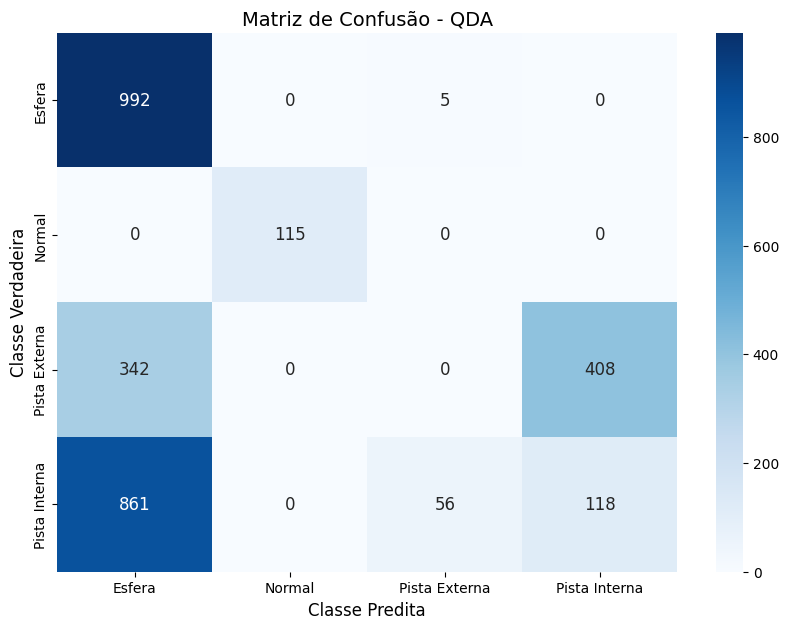


--- Verificando Acurácia no TREINO para QDA ---
Acurácia no TREINO: 76.90%
-> Modelo NEM SEQUER aprendeu os dados sintéticos (Problema maior)

  Resultados para o modelo: SVM
Acurácia: 0.2554 (ou 25.54%)

Relatório de Classificação:
               precision    recall  f1-score   support

       Esfera       0.05      0.04      0.04       997
       Normal       1.00      1.00      1.00       115
Pista Externa       0.17      0.24      0.19       750
Pista Interna       0.48      0.39      0.43      1035

     accuracy                           0.26      2897
    macro avg       0.42      0.42      0.42      2897
 weighted avg       0.27      0.26      0.26      2897

Matriz de Confusão:


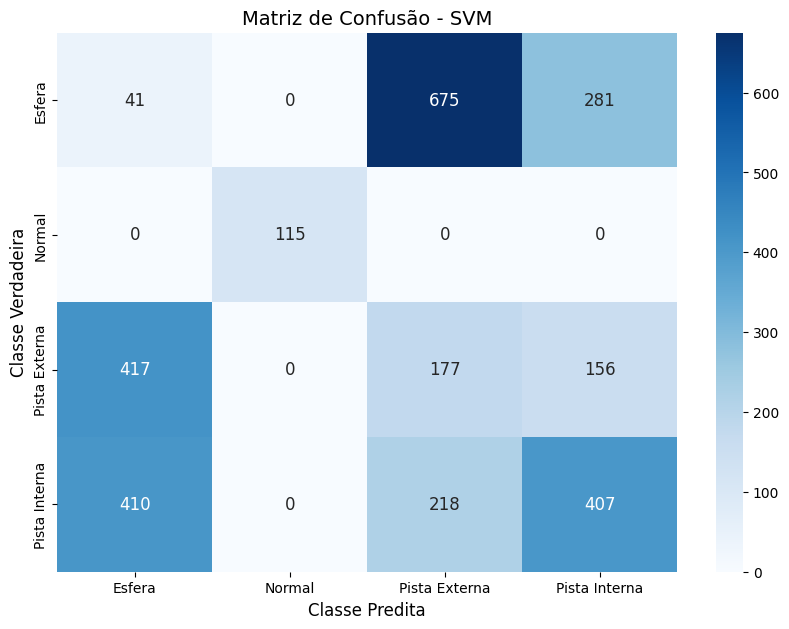


--- Verificando Acurácia no TREINO para SVM ---
Acurácia no TREINO: 91.05%
-> Modelo NEM SEQUER aprendeu os dados sintéticos (Problema maior)

  Resultados para o modelo: XGBoost
Acurácia: 0.5305 (ou 53.05%)

Relatório de Classificação:
               precision    recall  f1-score   support

       Esfera       0.66      0.58      0.62       997
       Normal       1.00      1.00      1.00       115
Pista Externa       0.25      0.21      0.23       750
Pista Interna       0.53      0.66      0.59      1035

     accuracy                           0.53      2897
    macro avg       0.61      0.61      0.61      2897
 weighted avg       0.52      0.53      0.52      2897

Matriz de Confusão:


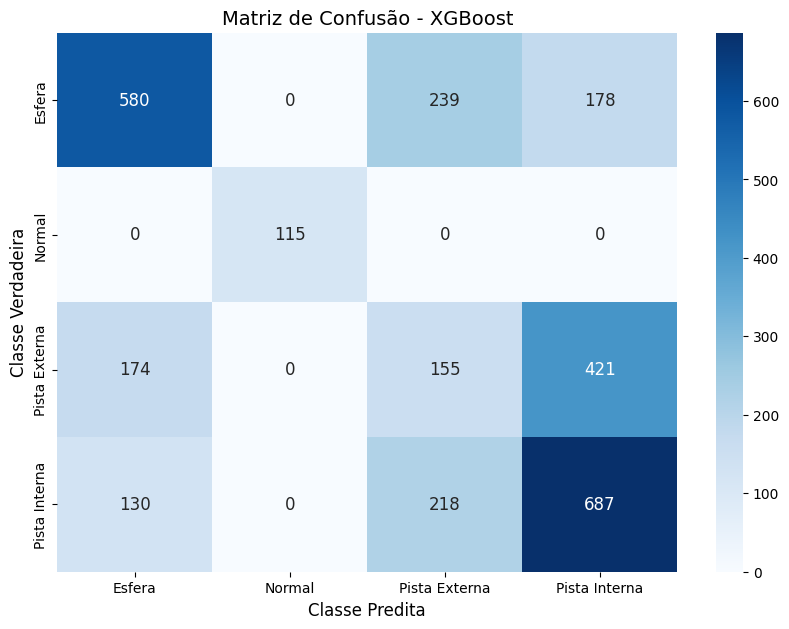


--- Verificando Acurácia no TREINO para XGBoost ---
Acurácia no TREINO: 99.97%
-> Modelo aprendeu os dados sintéticos (Isso é o esperado)


In [7]:
# =============================================================================
# BLOCO 5: TREINAMENTO E AVALIAÇÃO DOS MODELOS (QDA, SVM, XGBOOST)
# =============================================================================

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- 1. CARREGAR OS DADOS ---

# Caminho onde os CSVs foram salvos (ajuste se for diferente)
caminho_base_output = r'C:\Users\vinic\OneDrive\Documentos\Graduação\TG\Dataset\TCC'
caminho_csv_treino = os.path.join(caminho_base_output, 'df_treino_features.csv')
caminho_csv_teste = os.path.join(caminho_base_output, 'df_teste_features.csv')

try:
    df_treino = pd.read_csv(caminho_csv_treino)
    df_teste = pd.read_csv(caminho_csv_teste)
    print("Arquivos CSV carregados com sucesso!")
    print(f"Amostras de Treino: {len(df_treino)}, Amostras de Teste: {len(df_teste)}")
except FileNotFoundError:
    print(f"ERRO: Arquivos CSV não encontrados no caminho: {caminho_base_output}")
    print("Verifique se o Bloco 4 foi executado e os arquivos estão no local correto.")
    # Se der erro aqui, não continue o script
    raise

# --- 2. PREPARAÇÃO DOS DADOS (PRÉ-PROCESSAMENTO) ---

# Definir colunas de features e a coluna alvo
# (Baseado na saída do Bloco 3)
feature_columns = [
    'TF2_std', 'TF3_rms', 'TF4_fator_forma',
    'FF2_freq_central', 'FF3_rms_freq', 'FF5_assimetria_espectral',
    'FF_pico_50_200Hz'
]
target_column = 'tipo_falha_adicionada'

# Separar X (features) e y (alvo)
X_treino = df_treino[feature_columns]
y_treino = df_treino[target_column]

X_teste = df_teste[feature_columns]
y_teste = df_teste[target_column]

# --- 2a. Label Encoding (para a variável alvo 'y') ---
# Modelos precisam de alvos numéricos (ex: 0, 1, 2) em vez de ('Normal', 'Esfera', ...)
le = LabelEncoder()
y_treino_encoded = le.fit_transform(y_treino)
y_teste_encoded = le.transform(y_teste) # Usa o 'transform' para garantir a mesma ordem

# Salvar os nomes das classes para os relatórios
class_names = le.classes_
print(f"\nClasses (alvo) codificadas: {list(class_names)}")

# --- 2b. Feature Scaling (para as features 'X') ---
# (Importante para SVM e QDA)
scaler = StandardScaler()
X_treino_scaled = scaler.fit_transform(X_treino)
X_teste_scaled = scaler.transform(X_teste) # Apenas 'transform' no teste (evita data leakage)

print("\nPré-processamento concluído: LabelEncoder e StandardScaler aplicados.")

# --- 3. DEFINIÇÃO E TREINAMENTO DOS MODELOS ---

# Dicionário com os modelos a serem treinados
models = {
    'QDA': QuadraticDiscriminantAnalysis(),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# Dicionário para armazenar os modelos treinados
trained_models = {}

print("\n--- INICIANDO TREINAMENTO DOS MODELOS ---")
for name, model in models.items():
    print(f"Treinando {name}...")
    model.fit(X_treino_scaled, y_treino_encoded)
    trained_models[name] = model
print("--- TREINAMENTO CONCLUÍDO ---")

# --- 4. AVALIAÇÃO DOS MODELOS NO CONJUNTO DE TESTE ---

print("\n--- AVALIAÇÃO DOS MODELOS NO CONJUNTO DE TESTE ---")

for name, model in trained_models.items():
    # Fazer predições no conjunto de teste
    y_pred = model.predict(X_teste_scaled)
    
    # Calcular Acurácia
    accuracy = accuracy_score(y_teste_encoded, y_pred)
    
    print(f"\n=======================================================")
    print(f"  Resultados para o modelo: {name}")
    print(f"=======================================================")
    print(f"Acurácia: {accuracy:.4f} (ou {accuracy*100:.2f}%)")
    
    # Exibir Relatório de Classificação
    print("\nRelatório de Classificação:")
    print(classification_report(y_teste_encoded, y_pred, target_names=class_names, zero_division=0))
    
    # Exibir Matriz de Confusão
    print("Matriz de Confusão:")
    cm = confusion_matrix(y_teste_encoded, y_pred)
    
    # Plotar a Matriz de Confusão
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                annot_kws={"size": 12}) # Aumenta o tamanho da fonte
    plt.xlabel('Classe Predita', fontsize=12)
    plt.ylabel('Classe Verdadeira', fontsize=12)
    plt.title(f'Matriz de Confusão - {name}', fontsize=14)
    plt.show()

    # =================================================================
    # VERIFICAÇÃO: Testando a performance no PRÓPRIO CONJUNTO DE TREINO
    # =================================================================
    print(f"\n--- Verificando Acurácia no TREINO para {name} ---")
    y_pred_treino = model.predict(X_treino_scaled)
    accuracy_treino = accuracy_score(y_treino_encoded, y_pred_treino)
    print(f"Acurácia no TREINO: {accuracy_treino*100:.2f}%")
    
    if accuracy_treino > 0.95:
        print("-> Modelo aprendeu os dados sintéticos (Isso é o esperado)")
    else:
        print("-> Modelo NEM SEQUER aprendeu os dados sintéticos (Problema maior)")
    # =================================================================

In [8]:
# Importações principais para o modelo
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np
import time

# =============================================================================
# PASSO 1: CARREGAR AS FUNÇÕES DE GERAÇÃO DE DADOS
# =============================================================================
# (Isto assume que 'cleaning-funcs.ipynb' está no mesmo diretório)
print("Carregando funções de 'cleaning-funcs.ipynb'...")
%run cleaning-funcs.ipynb
print("Funções carregadas.")

# =============================================================================
# BLOCO DE TESTE DE HIPERPARÂMETROS (XGBoost)
# =============================================================================

# (Assumindo que Bloco 1 do 'clean-and-transformation' já foi executado
# e 'dicionario_treino', 'dicionario_teste', 'TAXA_AMOSTRAL', 
# 'params_drive_end' estão em memória)

print("\n--- Iniciando Iteração de Hiperparâmetros para Geração de Dados ---")

# --- 1. Parâmetros Fixos (Baseados no Bloco 2 original) ---
amplitudes_referencia = {
    'Drive End': {'Esfera': 0.0001, 'Pista Interna': 0.001, 'Pista Externa': 0.0001}
}
fases_originais = [0, np.pi/2, np.pi, 3*np.pi/2]
multiplicadores_originais = [1, 5, 10]
freq_natural_original = 3278

# --- 2. Grade de Parâmetros para Iterar ---
lista_damping_ratio = [0.1, 0.3, 0.5]
lista_duracao_pulso = [0.05, 0.1]

lista_resultados_finais = []

# --- 3. Loop de Iteração ---
for damping in lista_damping_ratio:
    for duracao_pulso in lista_duracao_pulso:
        
        iter_params = f"Damping: {damping}, Duração Pulso: {duracao_pulso}s"
        print(f"\n--- Iniciando Teste com: {iter_params} ---")
        start_time = time.time()

        # =======================================================
        # ETAPA 1: GERAÇÃO E EXTRAÇÃO DE DADOS ON-THE-FLY
        # =======================================================
        
        # 1.1. Gerar Sinais Sintéticos
        # (Chama a função importada de 'cleaning-funcs.ipynb')
        df_sinais_treino = gerar_dados_sinteticos_treino(
            dicionario_treino=dicionario_treino,
            TAXA_AMOSTRAL=TAXA_AMOSTRAL,
            params_drive_end=params_drive_end,
            amplitudes_referencia=amplitudes_referencia,
            multiplicadores=multiplicadores_originais,
            fases_para_adicionar_rad=fases_originais,
            freq_natural_hz=freq_natural_original,
            damping_ratio=damping,
            duracao_pulso_seg=duracao_pulso
        )
        
        # 1.2. Extrair Features
        # (Chama a função importada de 'cleaning-funcs.ipynb')
        df_treino, df_teste = extrair_features_treino_teste(
            df_sinais_treino=df_sinais_treino, 
            dicionario_teste=dicionario_teste, 
            TAXA_AMOSTRAL=TAXA_AMOSTRAL
        )
        
        # =======================================================
        # ETAPA 2: TREINAMENTO E AVALIAÇÃO (Lógica do 'models.ipynb')
        # =======================================================
        
        # 2.1. Preparação dos Dados
        colunas_features = [
            'TF2_std', 'TF3_rms', 'TF4_fator_forma', 
            'FF2_freq_central', 'FF3_rms_freq', 'FF5_assimetria_espectral', 
            'FF_pico_50_200Hz'
        ]
        coluna_target = 'tipo_falha_adicionada'

        df_treino[coluna_target] = df_treino[coluna_target].astype(str)
        df_teste[coluna_target] = df_teste[coluna_target].astype(str)

        le = LabelEncoder()
        y_treino = le.fit_transform(df_treino[coluna_target])
        y_teste = le.transform(df_teste[coluna_target])

        X_treino = df_treino[colunas_features]
        X_teste = df_teste[colunas_features]
        
        mapa_classes = {i: c for i, c in enumerate(le.classes_)}
        print(f"Classes para o modelo: {mapa_classes}")

        # 2.2. Treinamento do XGBoost
        model_xgb = xgb.XGBClassifier(
            use_label_encoder=False,
            eval_metric='mlogloss',
            objective='multi:softmax',
            num_class=len(mapa_classes),
            random_state=42
        )
        
        print(f"Treinando XGBoost com {len(X_treino)} amostras de treino...")
        model_xgb.fit(X_treino, y_treino)

        # 2.3. Avaliação
        print("Avaliando no conjunto de teste...")
        y_pred = model_xgb.predict(X_teste)
        
        accuracy = accuracy_score(y_teste, y_pred)
        report = classification_report(y_teste, y_pred, target_names=le.classes_, output_dict=True)
        end_time = time.time()
        
        # 2.4. Armazenar Resultados
        lista_resultados_finais.append({
            'damping_ratio': damping,
            'duracao_pulso_seg': duracao_pulso,
            'accuracy': accuracy,
            'f1_normal': report['Normal']['f1-score'],
            'f1_esfera': report['Esfera']['f1-score'],
            'f1_pista_interna': report['Pista Interna']['f1-score'],
            'f1_pista_externa': report['Pista Externa']['f1-score'],
            'f1_macro_avg': report['macro avg']['f1-score'],
            'tempo_exec_seg': (end_time - start_time)
        })
        
        print(f"Teste Concluído. Acurácia: {accuracy:.4f}. Tempo: {(end_time - start_time):.2f}s")


# --- 4. Exibição dos Resultados Finais ---
print("\n\n--- COMPILAÇÃO DOS RESULTADOS DA ITERAÇÃO ---")
df_resultados = pd.DataFrame(lista_resultados_finais)

# Ordena pelos melhores resultados (ex: maior acurácia ou F1-Score)
df_resultados = df_resultados.sort_values(by='f1_macro_avg', ascending=False)

print(df_resultados.to_markdown(index=False))

Carregando funções de 'cleaning-funcs.ipynb'...
Iniciando a leitura e segmentação dos arquivos em 'C:\Users\vinic\OneDrive\Documentos\Graduação\TG\Dataset'...
Dados normais serão divididos (80% treino / 20% teste).
Dados de falha real irão 100% para o teste.

--- Processo Concluído! ---
Total de segmentos de TREINO (APENAS 80% normais): 470
Total de segmentos de TESTE (falhas reais + 20% normais): 2897

Exemplo de um segmento de TREINO (chave: '1730_Normal_DE_treino_seg_0'):
   amplitude   arquivo_origem  rotacao_rpm tipo_falha diametro_falha  \
0   0.014603  1730_Normal.npz         1730     Normal            N/A   
1   0.054449  1730_Normal.npz         1730     Normal            N/A   
2   0.107646  1730_Normal.npz         1730     Normal            N/A   
3   0.133722  1730_Normal.npz         1730     Normal            N/A   
4   0.112652  1730_Normal.npz         1730     Normal            N/A   

  local_sensor  
0    Drive End  
1    Drive End  
2    Drive End  
3    Drive End  
4 

C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:199: UserWarning: [19:51:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Avaliando no conjunto de teste...
Teste Concluído. Acurácia: 0.3573. Tempo: 12.04s

--- Iniciando Teste com: Damping: 0.1, Duração Pulso: 0.1s ---
Usando 470 segmentos normais de TREINO para gerar dados sintéticos.
Modelo de White (Eq. 9) ativado. Freq. Natural: 3278 Hz, Amortecimento: 0.1, Duração Pulso: 0.1s


C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_clas


Adicionando os 470 segmentos normais de TREINO ao conjunto de dados...

--- Geração de Dados de Treino Concluída! ---
Total de 17390 segmentos (sintéticos + normais) gerados para o conjunto de TREINO.

--- Exemplo do DataFrame de Sinais de Treino Gerado ---
      tipo_falha_adicionada   rpm  multiplicador_amplitude  \
17385                Normal  1797                        0   
17386                Normal  1797                        0   
17387                Normal  1797                        0   
17388                Normal  1797                        0   
17389                Normal  1797                        0   

       fase_adicionada_rad                   base_normal  
17385                  0.0  1797_Normal_DE_treino_seg_62  
17386                  0.0  1797_Normal_DE_treino_seg_63  
17387                  0.0  1797_Normal_DE_treino_seg_64  
17388                  0.0  1797_Normal_DE_treino_seg_65  
17389                  0.0  1797_Normal_DE_treino_seg_66  
--- Iniciando 

C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:199: UserWarning: [19:51:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Avaliando no conjunto de teste...
Teste Concluído. Acurácia: 0.3573. Tempo: 12.71s

--- Iniciando Teste com: Damping: 0.3, Duração Pulso: 0.05s ---
Usando 470 segmentos normais de TREINO para gerar dados sintéticos.
Modelo de White (Eq. 9) ativado. Freq. Natural: 3278 Hz, Amortecimento: 0.3, Duração Pulso: 0.05s


C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_clas


Adicionando os 470 segmentos normais de TREINO ao conjunto de dados...

--- Geração de Dados de Treino Concluída! ---
Total de 17390 segmentos (sintéticos + normais) gerados para o conjunto de TREINO.

--- Exemplo do DataFrame de Sinais de Treino Gerado ---
      tipo_falha_adicionada   rpm  multiplicador_amplitude  \
17385                Normal  1797                        0   
17386                Normal  1797                        0   
17387                Normal  1797                        0   
17388                Normal  1797                        0   
17389                Normal  1797                        0   

       fase_adicionada_rad                   base_normal  
17385                  0.0  1797_Normal_DE_treino_seg_62  
17386                  0.0  1797_Normal_DE_treino_seg_63  
17387                  0.0  1797_Normal_DE_treino_seg_64  
17388                  0.0  1797_Normal_DE_treino_seg_65  
17389                  0.0  1797_Normal_DE_treino_seg_66  
--- Iniciando 

C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:199: UserWarning: [19:52:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Avaliando no conjunto de teste...
Teste Concluído. Acurácia: 0.3573. Tempo: 13.52s

--- Iniciando Teste com: Damping: 0.3, Duração Pulso: 0.1s ---
Usando 470 segmentos normais de TREINO para gerar dados sintéticos.
Modelo de White (Eq. 9) ativado. Freq. Natural: 3278 Hz, Amortecimento: 0.3, Duração Pulso: 0.1s


C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_clas


Adicionando os 470 segmentos normais de TREINO ao conjunto de dados...

--- Geração de Dados de Treino Concluída! ---
Total de 17390 segmentos (sintéticos + normais) gerados para o conjunto de TREINO.

--- Exemplo do DataFrame de Sinais de Treino Gerado ---
      tipo_falha_adicionada   rpm  multiplicador_amplitude  \
17385                Normal  1797                        0   
17386                Normal  1797                        0   
17387                Normal  1797                        0   
17388                Normal  1797                        0   
17389                Normal  1797                        0   

       fase_adicionada_rad                   base_normal  
17385                  0.0  1797_Normal_DE_treino_seg_62  
17386                  0.0  1797_Normal_DE_treino_seg_63  
17387                  0.0  1797_Normal_DE_treino_seg_64  
17388                  0.0  1797_Normal_DE_treino_seg_65  
17389                  0.0  1797_Normal_DE_treino_seg_66  
--- Iniciando 

C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:199: UserWarning: [19:52:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Avaliando no conjunto de teste...
Teste Concluído. Acurácia: 0.3573. Tempo: 13.60s

--- Iniciando Teste com: Damping: 0.5, Duração Pulso: 0.05s ---
Usando 470 segmentos normais de TREINO para gerar dados sintéticos.
Modelo de White (Eq. 9) ativado. Freq. Natural: 3278 Hz, Amortecimento: 0.5, Duração Pulso: 0.05s


C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_clas


Adicionando os 470 segmentos normais de TREINO ao conjunto de dados...

--- Geração de Dados de Treino Concluída! ---
Total de 17390 segmentos (sintéticos + normais) gerados para o conjunto de TREINO.

--- Exemplo do DataFrame de Sinais de Treino Gerado ---
      tipo_falha_adicionada   rpm  multiplicador_amplitude  \
17385                Normal  1797                        0   
17386                Normal  1797                        0   
17387                Normal  1797                        0   
17388                Normal  1797                        0   
17389                Normal  1797                        0   

       fase_adicionada_rad                   base_normal  
17385                  0.0  1797_Normal_DE_treino_seg_62  
17386                  0.0  1797_Normal_DE_treino_seg_63  
17387                  0.0  1797_Normal_DE_treino_seg_64  
17388                  0.0  1797_Normal_DE_treino_seg_65  
17389                  0.0  1797_Normal_DE_treino_seg_66  
--- Iniciando 

C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:199: UserWarning: [19:52:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Avaliando no conjunto de teste...
Teste Concluído. Acurácia: 0.3573. Tempo: 10.37s

--- Iniciando Teste com: Damping: 0.5, Duração Pulso: 0.1s ---
Usando 470 segmentos normais de TREINO para gerar dados sintéticos.
Modelo de White (Eq. 9) ativado. Freq. Natural: 3278 Hz, Amortecimento: 0.5, Duração Pulso: 0.1s


C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_clas


Adicionando os 470 segmentos normais de TREINO ao conjunto de dados...

--- Geração de Dados de Treino Concluída! ---
Total de 17390 segmentos (sintéticos + normais) gerados para o conjunto de TREINO.

--- Exemplo do DataFrame de Sinais de Treino Gerado ---
      tipo_falha_adicionada   rpm  multiplicador_amplitude  \
17385                Normal  1797                        0   
17386                Normal  1797                        0   
17387                Normal  1797                        0   
17388                Normal  1797                        0   
17389                Normal  1797                        0   

       fase_adicionada_rad                   base_normal  
17385                  0.0  1797_Normal_DE_treino_seg_62  
17386                  0.0  1797_Normal_DE_treino_seg_63  
17387                  0.0  1797_Normal_DE_treino_seg_64  
17388                  0.0  1797_Normal_DE_treino_seg_65  
17389                  0.0  1797_Normal_DE_treino_seg_66  
--- Iniciando 

C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:199: UserWarning: [19:52:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Avaliando no conjunto de teste...
Teste Concluído. Acurácia: 0.3573. Tempo: 10.81s


--- COMPILAÇÃO DOS RESULTADOS DA ITERAÇÃO ---
|   damping_ratio |   duracao_pulso_seg |   accuracy |   f1_normal |   f1_esfera |   f1_pista_interna |   f1_pista_externa |   f1_macro_avg |   tempo_exec_seg |
|----------------:|--------------------:|-----------:|------------:|------------:|-------------------:|-------------------:|---------------:|-----------------:|
|             0.1 |                0.05 |   0.357266 |           0 |           0 |           0.531724 |                  0 |       0.132931 |          12.0414 |
|             0.1 |                0.1  |   0.357266 |           0 |           0 |           0.531314 |                  0 |       0.132829 |          12.7058 |
|             0.5 |                0.05 |   0.357266 |           0 |           0 |           0.530225 |                  0 |       0.132556 |          10.368  |
|             0.3 |                0.05 |   0.357266 |          

C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_clas